In [10]:
import math
import pickle
import gzip
import numpy as np
from math import exp
import pandas as pd
import seaborn as sns
import sklearn
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


For this project I will exploring a gym/workout dataset from Kaggle which can be downloaded here: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset

In the analysis I will attempt to find significant features, correlations, and come to a conclusions about my findings. 

In [ ]:
path_to_csv = r"C:\Users\Kyle\Downloads\gym_members_exercise_tracking.csv" # adjust based on location of dataset download

In [11]:
df = pd.read_csv(path_to_csv)

In [12]:
df.columns

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI'],
      dtype='object')

### Initial Inspection of Dataset

In [13]:
print(f"Maxmium Age: {df['Age'].max()}")
print(f"Minimum Age: {df['Age'].min()}")
print(f"Average Age:  {round(df['Age'].mean(),0)}")
print(f"Rows of Female data: {len(df[df['Gender']=='Female'])}")
print(f"Rows of Male data: {len(df[df['Gender']=='Male'])}")

df_test = df[df['Gender']!='Male']
df_test2 = df_test[df_test['Gender']!='Female']

# len(df[df['Gender']!='Male' && df['Gender']!='Female'])
# One Meter = 3.28084 Feet
# One kilogram = 2.20462262185 lb

ft_conversion = 3.28084
lb_conversion = 2.20462262185

df['height_ft'] = df['Height (m)'].apply(lambda x: x*ft_conversion)
df['weight_lb'] = df['Weight (kg)'].apply(lambda x: x*lb_conversion)


Maxmium Age: 59
Minimum Age: 18
Average Age:  39.0
Rows of Female data: 462
Rows of Male data: 511


#### Running some calculations after splitting between Male and Female

In [14]:


df['idx'] = 0 # for the purpose of a dummy column to use as count param

age_pivot = pd.pivot_table(df, index=['Age'], values='idx', columns='Gender', aggfunc={'idx':'count'})
mdf_age = pd.DataFrame(age_pivot.sort_values(by='Male', ascending=False)).reset_index()
fdf_age = pd.DataFrame(age_pivot.sort_values(by='Female', ascending=False)).reset_index()
mdf_age = mdf_age.drop(columns='Female')
fdf_age = fdf_age.drop(columns='Male')
m_wavg = (mdf_age['Age'] * mdf_age['Male']).sum() / mdf_age['Male'].sum()
f_wavg = (fdf_age['Age'] * fdf_age['Female']).sum() / fdf_age['Female'].sum()

print(f"Male Average Age:{round(male['Age'].mean(),2)} | Male (w)Average Age:{round(m_wavg,2)}")
print(f"Female Average Age:{round(female['Age'].mean(),2)} | Female (w)Average Age:{round(f_wavg,2)}")

Male Average Age:39.0 | Male (w)Average Age:39.0
Female Average Age:38.34 | Female (w)Average Age:38.34


The weighted and normal averages are the same which indicates a well distributed dataset, we may not have to drop any rows but we will also need to check for Outliers

#### Convert height and weight to Imperial units

In [15]:
df['height_inches'] = df['height_ft'].apply(lambda x: float(str(x).split(".")[-1])*12)
df['height_inches'] = df['height_ft'].astype(float).apply(lambda x: round(x,0))
df['height_feet_adj'] = df['height_ft'].apply(lambda x: str(x).split(".")[0])
df['height_feet_adj'] = df['height_feet_adj'].astype(float)
df['height_full_inches'] = df['height_ft'].apply(lambda x: round(x*12,0))

male = df[df['Gender']=='Male']
female = df[df['Gender']=='Female']

### Visual Analysis of Entire Dataset as well as Male/Female Split

#### Height vs Weight Hexbin Plot

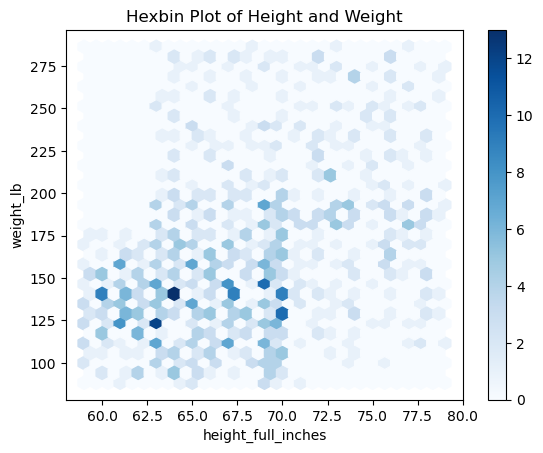

In [16]:
df.plot.hexbin(x='height_full_inches', y='weight_lb', gridsize=30, cmap='Blues')
plt.title('Hexbin Plot of Height and Weight')
plt.show()


The sweetspot looks to be between 125 to 150 lb (weight) and 62.5 to 65 inches (height), although my guess would be the genders are interfering with each other, so we will visualize again after splitting 

#### Height vs Weight Pair Plot

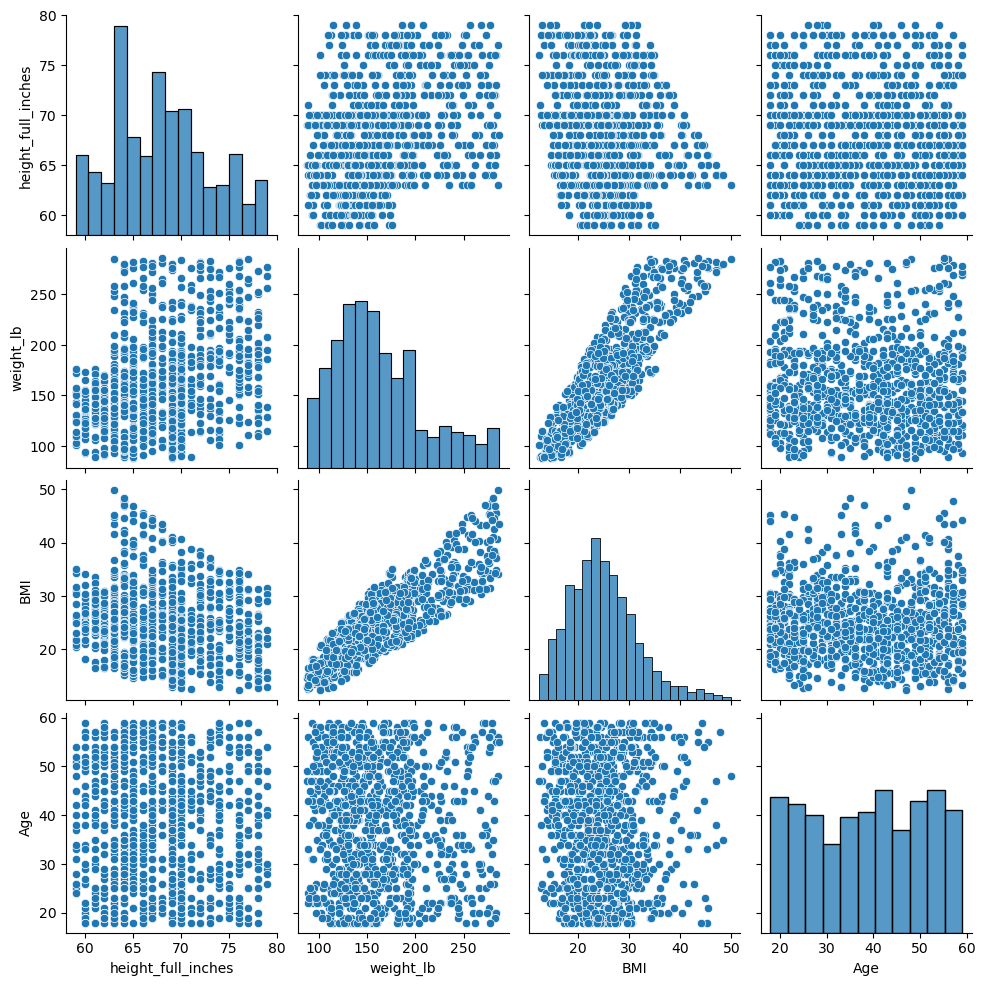

In [17]:
sns.pairplot(df[['height_full_inches', 'weight_lb', 'BMI', 'Age']])
plt.show()

The pair plot displas a correlation between weight_lb and BMI, which is intuitive

#### Visualizing Hexbin Plot for both the Male and Female dataset

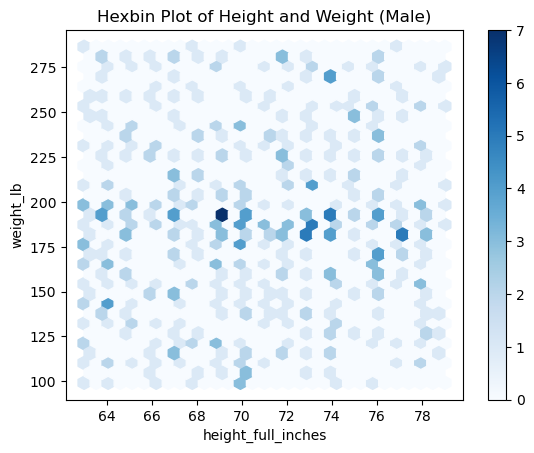

In [18]:
male.plot.hexbin(x='height_full_inches', y='weight_lb', gridsize=30, cmap='Blues')
plt.title('Hexbin Plot of Height and Weight (Male)')
plt.show()

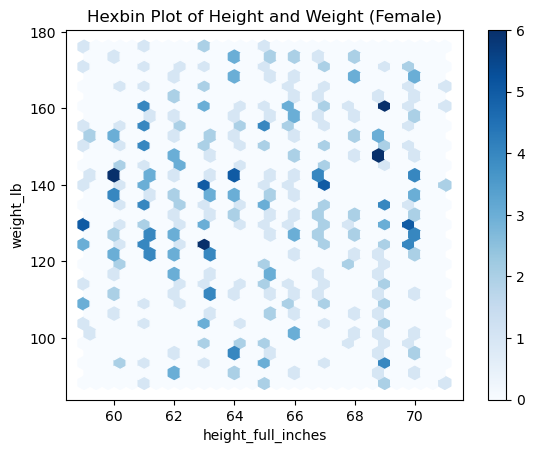

In [19]:
female.plot.hexbin(x='height_full_inches', y='weight_lb', gridsize=30, cmap='Blues')
plt.title('Hexbin Plot of Height and Weight (Female)')
plt.show()

Interestingly, the Female Hexbin Plot looks to show a more dispersed set of heights and weights while the Male Plot is more concentrated around the 175 to 200 lb point regardless of height

#### Heatmap Correlation

<Axes: >

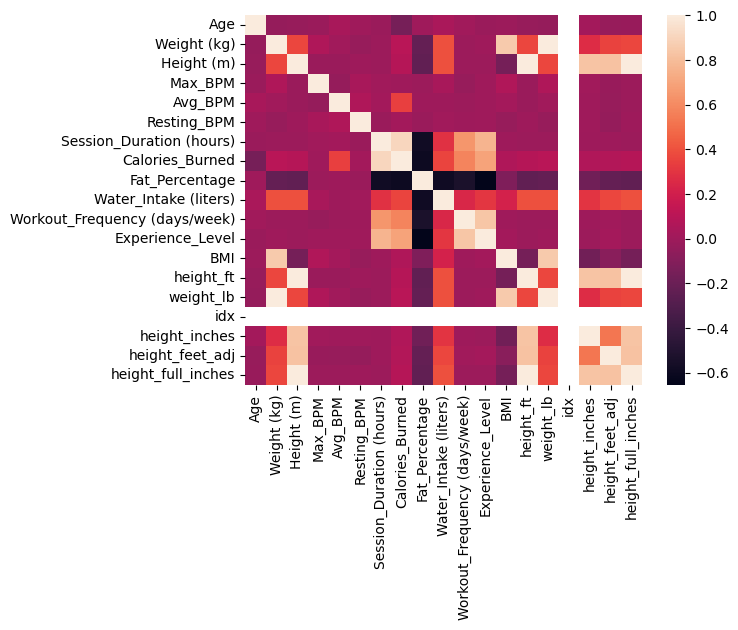

In [20]:
sns.heatmap(df.corr(method='pearson', min_periods=1, numeric_only=True))

### Looking for Outliers

#### Z-score Method

In [21]:
z_scores = stats.zscore(df['BMI'])


outliers_z = df[abs(z_scores) > 3]


outliers_z

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,height_ft,weight_lb,idx,height_inches,height_feet_adj,height_full_inches
133,21,Male,125.2,1.66,196,159,60,1.38,1207.0,HIIT,...,3.4,3,2,45.43,5.446194,276.018752,0,5.0,5.0,65.0
251,33,Male,117.0,1.61,166,130,55,1.04,744.0,HIIT,...,2.4,3,2,45.14,5.282152,257.940847,0,5.0,5.0,63.0
261,57,Male,126.8,1.63,161,133,73,0.96,632.0,Yoga,...,2.1,2,1,47.72,5.347769,279.546148,0,5.0,5.0,64.0
291,55,Male,128.4,1.68,178,165,52,1.13,923.0,Cardio,...,2.6,4,2,45.49,5.511811,283.073545,0,6.0,5.0,66.0
470,34,Male,124.6,1.63,161,136,66,1.41,1055.0,HIIT,...,2.8,3,2,46.90,5.347769,274.695979,0,5.0,5.0,64.0
687,18,Male,125.9,1.67,172,153,60,1.46,1229.0,Yoga,...,2.2,3,2,45.14,5.479003,277.561988,0,5.0,5.0,66.0
710,38,Male,123.3,1.62,161,165,65,1.34,1216.0,Yoga,...,2.3,4,2,46.98,5.314961,271.829969,0,5.0,5.0,64.0
854,48,Male,129.2,1.61,193,167,62,1.06,876.0,Yoga,...,2.9,4,2,49.84,5.282152,284.837243,0,5.0,5.0,63.0
868,47,Male,127.8,1.65,198,157,60,0.77,598.0,Cardio,...,3.5,2,1,46.94,5.413386,281.750771,0,5.0,5.0,65.0
945,35,Male,127.1,1.62,187,128,69,1.02,718.0,Strength,...,3.4,4,2,48.43,5.314961,280.207535,0,5.0,5.0,64.0


#### Deviation from the Mean

In [22]:
mean_bmi = df['BMI'].mean()


df['BMI_deviation'] = df['BMI'] - mean_bmi


threshold = 12
outliers_bmi = df[abs(df['BMI_deviation']) > threshold]

# Display the outliers
outliers_bmi.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,Workout_Frequency (days/week),Experience_Level,BMI,height_ft,weight_lb,idx,height_inches,height_feet_adj,height_full_inches,BMI_deviation
10,41,Male,120.8,1.67,188,146,54,0.82,593.0,HIIT,...,2,1,43.31,5.479003,266.318413,0,5.0,5.0,66.0,18.397873
12,57,Male,112.5,1.61,195,165,61,1.24,1013.0,Cardio,...,3,2,43.40,5.282152,248.020045,0,5.0,5.0,63.0,18.487873
23,29,Male,120.9,1.78,197,168,65,0.78,721.0,Yoga,...,2,1,38.16,5.839895,266.538875,0,6.0,5.0,70.0,13.247873
35,26,Male,127.6,1.73,167,160,62,1.32,1162.0,Strength,...,3,1,42.63,5.675853,281.309847,0,6.0,5.0,68.0,17.717873
44,37,Male,124.2,1.76,168,158,50,1.50,1304.0,HIIT,...,2,1,40.10,5.774278,273.814130,0,6.0,5.0,69.0,15.187873


In [23]:
print(f"Male Outliers (deviation from Mean): {len(outliers_bmi[outliers_bmi['Gender']=='Male'])}")
print(f"Female Outliers (deviation from Mean): {len(outliers_bmi[outliers_bmi['Gender']=='Female'])}")

Male Outliers (deviation from Mean): 55
Female Outliers (deviation from Mean): 3


There are some outliers, but the optimal method (using z-score) only returns 10 outliers and the BMI is not neccessarilly the target feature for the analysis coming up

### Regression Analysis

#### Calories Burned

##### Male Dataset

In [24]:
X = male[['Age', 'BMI', 'Session_Duration (hours)', 'weight_lb', 'height_full_inches','Max_BPM', 'Avg_BPM', 'Resting_BPM']]
y = male['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r_squared = r2_score(y_test, y_pred)

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

print(f"R-squared value: {r_squared}")
print(coefficients)

R-squared value: 0.9804967044924138
                    Feature  Coefficient
0                       Age    -3.590673
1                       BMI     2.686667
2  Session_Duration (hours)   757.119044
3                 weight_lb    -0.329954
4        height_full_inches     1.723059
5                   Max_BPM     0.051347
6                   Avg_BPM     6.521755
7               Resting_BPM     0.605321


##### Female Dataset

In [25]:
X = female[['Age', 'BMI', 'Session_Duration (hours)', 'weight_lb', 'height_full_inches','Max_BPM', 'Avg_BPM', 'Resting_BPM']]
y = female['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r_squared = r2_score(y_test, y_pred)

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

print(f"R-squared value: {r_squared}")
print(coefficients)

R-squared value: 0.9837407638687924
                    Feature  Coefficient
0                       Age    -3.194865
1                       BMI     1.483310
2  Session_Duration (hours)   674.248146
3                 weight_lb    -0.204104
4        height_full_inches     1.271397
5                   Max_BPM    -0.083632
6                   Avg_BPM     5.860560
7               Resting_BPM    -0.037458


Both models show a high value for R-Squared indicating a strong fit between predictors and the target variable (calories burned)

Both models show the strongest correlation between Calories Burned and Session Duration. Essentially, for each additional hour of workout time, cthe alories burned will increase by about 675 to 750 calories.
The correlation is expected since longer workouts tend to burn more calories

### Post-Inspection of Dataset

We have found attributes which are correlated and determined the dataset is well distributed.
For the next task I want to use a Machine Learning model to predict calories burned based on the most efficient workout type and duration.

How important is Session Duration? Aside from Duration, what type of Workouts Burn the Most Calories?

#### Random Forest Method

##### Male Dataset

R-squared: 0.8821444673362203


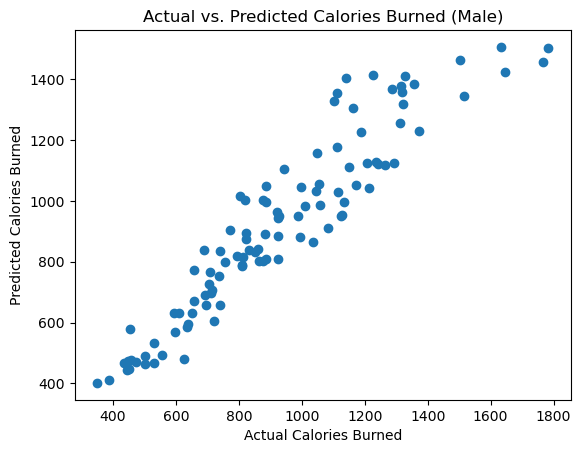

                    Feature  Importance
2  Session_Duration (hours)    0.887953
0                       Age    0.047338
1                       BMI    0.027472
3                 weight_lb    0.025182
4     Workout_Type_Strength    0.005279
5         Workout_Type_Yoga    0.003764
6             Dangerous_BPM    0.003012


In [26]:
data_encoded = pd.get_dummies(male, columns=['Workout_Type'], drop_first=True)


data_encoded['Dangerous_BPM'] = data_encoded['Max_BPM'].apply(lambda x: 1 if x >= 185 else 0)

X = data_encoded[['Age', 'BMI', 'Session_Duration (hours)', 'weight_lb'] + list(data_encoded.columns[-3:])]

y = male['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.title('Actual vs. Predicted Calories Burned (Male)')
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

##### Female Dataset

R-squared: 0.8529764480486836


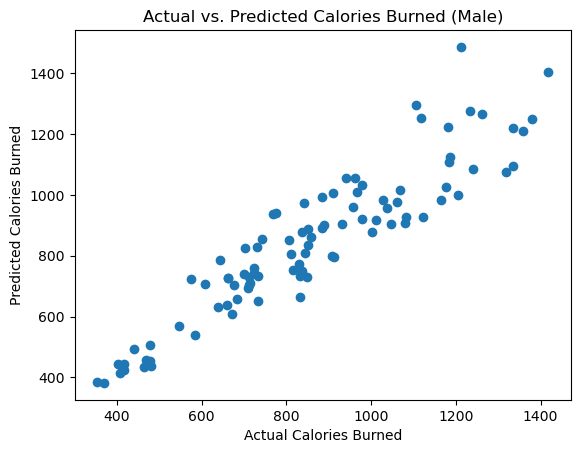

                    Feature  Importance
1  Session_Duration (hours)    0.890077
0                       Age    0.056026
2                 weight_lb    0.036670
5             Dangerous_BPM    0.006703
3     Workout_Type_Strength    0.005307
4         Workout_Type_Yoga    0.005216


In [27]:
data_encoded = pd.get_dummies(female, columns=['Workout_Type'], drop_first=True)


data_encoded['Dangerous_BPM'] = data_encoded['Max_BPM'].apply(lambda x: 1 if x >= 185 else 0)

X = data_encoded[['Age', 'Session_Duration (hours)', 'weight_lb',] + list(data_encoded.columns[-3:])]  # Last 3 are encoded workout types

y = female['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

# Plot actual vs. predicted calories burned
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.title('Actual vs. Predicted Calories Burned (Male)')
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

Conclusions: For both Male and Female datasets, Session Duration was by far the most significant determining factor of calories burned. Males have Session Duration at a level of 88% significance while Females have it slightly higher at 89%. Other features like Age, weight, and workout type have some impact but only between 1-5% level of significance. This indicates that while your Age and Workout Routine do matter somewhat, by far the most important feature that maximizes calories burned is the duration of the workout.

I also included 'Dangerous_BPM' as a new feature because I wanted to see how significant a high BPM (185 is "dangerous") is on the calories burned. While it does have some significance, it is not much. Which is to say, be safe with a workout as there is no need to push your heart to the edge as long as you are consistent and workout for a long duration.

The R-Squared is fairly high, indicating a strong fit between predictors and the target variable (calories burned)


### Comparing to another Model

#### Gradient Boosting Method

##### Male Dataset

R-squared: 0.8464921095793018


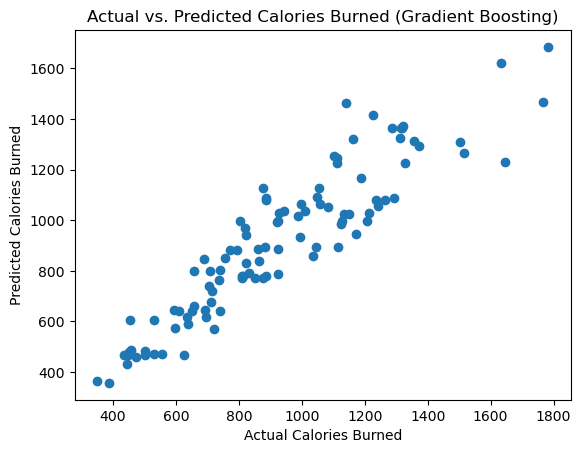

                    Feature  Importance
0  Session_Duration (hours)    0.979172
1     Workout_Type_Strength    0.011070
2         Workout_Type_Yoga    0.005315
3             Dangerous_BPM    0.004443


In [28]:
data_encoded = pd.get_dummies(male, columns=['Workout_Type'], drop_first=True)

data_encoded['Dangerous_BPM'] = data_encoded['Max_BPM'].apply(lambda x: 1 if x >= 185 else 0)

X = data_encoded[['Session_Duration (hours)'] + list(data_encoded.columns[-3:])]

y = male['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr_model = GradientBoostingRegressor(n_estimators=250, random_state=42)
gbr_model.fit(X_train, y_train)

y_pred = gbr_model.predict(X_test)

r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.title('Actual vs. Predicted Calories Burned (Gradient Boosting)')
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbr_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

##### Female Dataset

R-squared: 0.8359594871173233


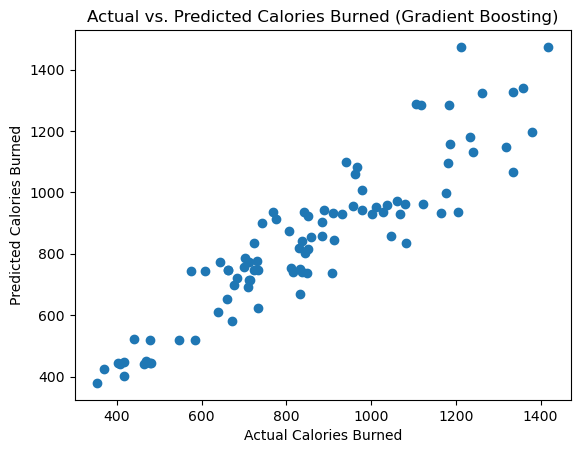

                    Feature  Importance
0  Session_Duration (hours)    0.980602
3         Workout_Type_Yoga    0.007127
2     Workout_Type_Strength    0.004877
4             Dangerous_BPM    0.004078
1             Dangerous_BPM    0.003317


In [29]:
data_encoded = pd.get_dummies(female, columns=['Workout_Type'], drop_first=True)

data_encoded['Dangerous_BPM'] = data_encoded['Max_BPM'].apply(lambda x: 1 if x >= 185 else 0)

X = data_encoded[['Session_Duration (hours)', 'Dangerous_BPM'] + list(data_encoded.columns[-3:])]

y = female['Calories_Burned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr_model = GradientBoostingRegressor(n_estimators=250, random_state=42)
gbr_model.fit(X_train, y_train)

y_pred = gbr_model.predict(X_test)

r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Calories Burned')
plt.ylabel('Predicted Calories Burned')
plt.title('Actual vs. Predicted Calories Burned (Gradient Boosting)')
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbr_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

Conclusions: Using the Gradient Boosting model, the significance of Session Duration is even higher for both the Male and Female datasets. 98% in both cases. However this comes with a slight trade off when comparing the R-Squared values. So while, the R-Squared is fairly high and indicates a strong fit, it is slightly less than that of the Random Forest model.

In this model I also wanted to include the workout type as one of the key features. While the type of workout is not super significant it is interesting to see Strength Training being more significant to Males while Yoga was more significant to Females. The data alone is not going to explain everything though. For example, it could be a culture thing or the "zeitgeist" of the digital world which encourages Males to go super hard at weight training and Females to focus on Yoga. The significance compared to the Session Duration is miniscule either way, but it is still interesting to see that comparison.